# Sprint 10 Project - Integrated Project

## Project Overview

**Project Objective -** In this project, I will prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for the heavy metals industry. The model I create should predict the amount of gold recovered from gold ore. I have the data on extraction and purification. The model will optimize for the production of gold concentrate and will aim to eliminate unprofitable parameters.

**For this project, we want to create a model to maximize the amount of gold concentration output throughout the gold extraction process-**
- **rougher concentrate recovery** (*rougher.output.recovery*)
- **final concentrate recovery** (*final.output.recovery*) 

I will explore, prepare, and train a model on data provided by Zafra to optimize these parameters.  

##  Import Libraries

In [1]:
# Import libraries required for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# To Create Training & Validation Sets
from sklearn.model_selection import train_test_split

# To calculate MAE
from sklearn.metrics import mean_absolute_error

# Regression Models 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Cross Validation Score For Model Evaluation 
from sklearn.model_selection import cross_val_score

# For make_scorer to use in cross validation 
from sklearn.metrics import make_scorer

# DummyRegressor
from sklearn.dummy import DummyRegressor 

# Show all columns when displaying dataframe
pd.set_option('display.max_columns', None)

# To disbale runtime warning during model training
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Data Preparation

### Read in Data Files

In [2]:
# Read in CSVs for training and testing our model
# Additionally the full dataset was provided for which the training and test sets came from 
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv') 

### Recovery Calculations

The following formula is used to simulate the recovery process of recovering gold from gold ore. For this exercise, we want to maximize the recovery coefficient.

![123](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_Recovery_1576238822_1589899219.jpg)

*__Where:__*

- **C —** share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
 - This is represented in the dataset as `rougher.output.concentrate_au`
- **F —** share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
 - This is represented in the dataset as `rougher.input.feed_au` 
- **T —** share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
 - This is represented in the dataset as `rougher.output.tail_au`

To predict the coefficient, we need to find the share of gold in the concentrate and the tails. 

####  Caclulate Recovery for rougher.output.recovery Feature
Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature.

In [3]:
# Create a function to calculate recovery
def recovery_calc(df, C, F, T):
    recovery = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return recovery

# Calculate the recovery for rows that don't have NaN in rougher.output.recovery
calculated_recovery = recovery_calc(gold_recovery_train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')

#### Find the MAE Between Calculations & Feature Values
Find the MAE between your calculations and the feature values. Provide findings.

In [4]:
# Create a list of the values in 'rougher.output.recovery' from the training set
actual_recovery = gold_recovery_train['rougher.output.recovery'].dropna().to_list()

# Using the actual recovery values and the calculated recovery values, calculate the MAE
print(f"The Mean Absolute Error is {mean_absolute_error(actual_recovery, calculated_recovery)}")

The Mean Absolute Error is 9.303415616264301e-15


**Findings -** Absolute Error is the amount of error in our measurements. It is the difference between the calculated value and true value. When using our recovery function to calculate the values for recovery, the difference between our prediction and the actual results is nearly 0. This means that our function for determining recovery is accurate in calculating 'rougher.output.recovery'.

### Analyze Features Not Aviailable in the Test Set
Analyze the features not available in the test set. What are these parameters? What is their type?

In [5]:
# Get list of features in each dataset
columns_in_train = list(gold_recovery_train.columns)
columns_in_test = list(gold_recovery_test.columns)

# Count the number of columns in the test and training set
print('The number of features in the training set is', len(columns_in_train))
print('The number of features in the test set is', len(columns_in_test))
print()

# Determine the difference in columns between the traning and the test set
difference =  gold_recovery_train[gold_recovery_train.columns.difference(gold_recovery_test.columns)].columns
print('The column count difference between the training and test set is', len(difference))
print()

# What are the parameters and what is their type (assuming datatype?)
gold_recovery_train[difference].info()

The number of features in the training set is 87
The number of features in the test set is 53

The column count difference between the training and test set is 34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_au                         16789 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_au                                16794 non-null  float6

**Findings -** There are 87 columns in the training set, however there are only 53 columns in the test set. The difference of 34 columns are the product parameters (output) and calculation characteristics (calculations) of each step in the process. These outputs are not feautures, but instead they are targets that we can use to train our model on predict given a set of inputs at each step of the process. Because the test set doesn't have targets, and we will want to compare our predictions our target predictions of the model on the test set to actual values, we will need to use the full dataset to add targets to the test data set.

### Perform Data Preprocessing

#### Explore Training Dataset

In [6]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(gold_recovery_train.isna().sum())
print()

# Check field with the most missing values
print('Check for Max Number of Missing Values')
print(gold_recovery_train.isna().sum().max())
print()

# Check for duplicate rows
print('Check for Duplicate Rows')
print('There are', gold_recovery_train.duplicated().sum(), 'duplicate rows')

# Check values for each column
# Commented out because output is too long in cells
print('\n Describe Dataframe')
#print(gold_recovery_train.describe())

# Check data types
print('\n Check Data Types')
print(gold_recovery_train.info())

Check for Missing Values
date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

Check for Max Number of Missing Values
2573

Check for Duplicate Rows
There are 0 duplicate rows

 Describe Dataframe

 Check Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              -------------- 

**Training Set Findings -** When checking the training set, I noticed the following - 
- There are missing values in many of the columns within the dataset
 - Because I am uncertain on how to replace these missing values, I am going to drop rows with missing values from the dataset. There are about ~17k values in each column and at most there are 2.5k missing values. We will drop the rows that have missing values because we still have thousands of other rows/values to train our model on.
- Datatypes do not need to be changed. Date will be dropped later on when we train our model, otherwise this would need to be cast to datetime.
- There are no duplicate rows in the tranining set.

#### Explore Test Dataset

In [7]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(gold_recovery_test.isna().sum())
print()

# Check field with the most missing values
print('Check for Max Number of Missing Values')
print(gold_recovery_test.isna().sum().max())
print()

# Check for duplicate rows
print('Check for Duplicate Rows')
print('There are', gold_recovery_test.duplicated().sum(), 'duplicate rows')

# Check values for each column
# Commented out because output is too long in cells
print('\n Describe Dataframe')
#print(gold_recovery_test.describe())

# Check data types
print('\n Check Data Types')
print(gold_recovery_test.info())

Check for Missing Values
date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10

**Test Findings -** When checking the test set, I noticed the following - 
- There are also missing values in many of the columns within the dataset
 - Similiar to the training dataset we are going to drop rows with any missing values
- Datatypes do not need to be changed. Date will be dropped later on when we train our model
- There are no duplicate rows

**NOTE -** Before dropping rows in the test set, I will first add in the target values from the full dataset based on `date` since this value isn't missing and `date` seems to be a primary key.

#### Add Targets From Full Dataset to Test Dataset

In [8]:
# Create dataframe of values that we need to add to the test dataframe
gold_recovery_full_targets = gold_recovery_full[['date','rougher.output.recovery', 'final.output.recovery']]

# Join targets from full dataset to test dataset on date
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full_targets, how ='inner', on = 'date')

# Check shape to make sure we didn't lose any rows and columns were merged
print(gold_recovery_test.shape)
print(gold_recovery_test.shape)

(5856, 55)
(5856, 55)


#### Drop Rows With Missing Values From Both Datasets
In this step we are going to rows with missing values



In [9]:
# Drop rows in training and test set
gold_recovery_train.dropna(inplace=True) 
gold_recovery_test.dropna(inplace=True) 

# Check for missing values in dataset after drop
print('Missing values in training data:', gold_recovery_train.isna().sum().sum())
print('Missing values in test data:', gold_recovery_test.isna().sum().sum())
print()

# Check shape of datasets after dropping rows with missing vales
print('Traning Set Shape:', gold_recovery_train.shape)
print('Test Set Shape:', gold_recovery_test.shape)

Missing values in training data: 0
Missing values in test data: 0

Traning Set Shape: (11017, 87)
Test Set Shape: (5229, 55)


## Analyze The Data

![Waterfall](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_ore_1591699963.jpg)

### Analyze Concentraction Change of Metals Depending on Purification Stage
**In this section, we want to take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage**

The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails. The two purification stages are - 
 - **primary_cleaner** — primary purification
 - **secondary_cleaner** — secondary purification
   - We will know the concentration from final.output.concentration

We will want to see how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage especially looking into the inputs and outputs of each stage.

**For clarity-sake, the scientific abbreviations of the metals are**
 - **Au** - Gold
 - **Ag** - Silver
 - **Pb** - Lead 
 
*__The stages are ordered like this -__* 
 1. Metal concentration before feeding into first purification 
  - 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au'
 2. Metal concentration after first purification stage (output of first stage and input into second stage)
  - 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb','primary_cleaner.output.concentrate_au'
 3. Metal concentration after second purificaion strage (output of second purificaion)
  - 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au'

Ag Concentration Change at Each Purification Step
The mean Ag concentration before primary purification is 11.84
The mean Ag concentration before secondary purification is 8.44
The mean Ag concentration after secondary purification is 5.16

Au Concentration Change at Each Purification Step
The mean Au concentration before primary purification is 19.78
The mean Au concentration before secondary purification is 32.38
The mean Au concentration after secondary purification is 44.13

Pb Concentration Change at Each Purification Step
The mean Pb concentration before primary purification is 7.61
The mean Pb concentration before secondary purification is 9.57
The mean Pb concentration after secondary purification is 10.17



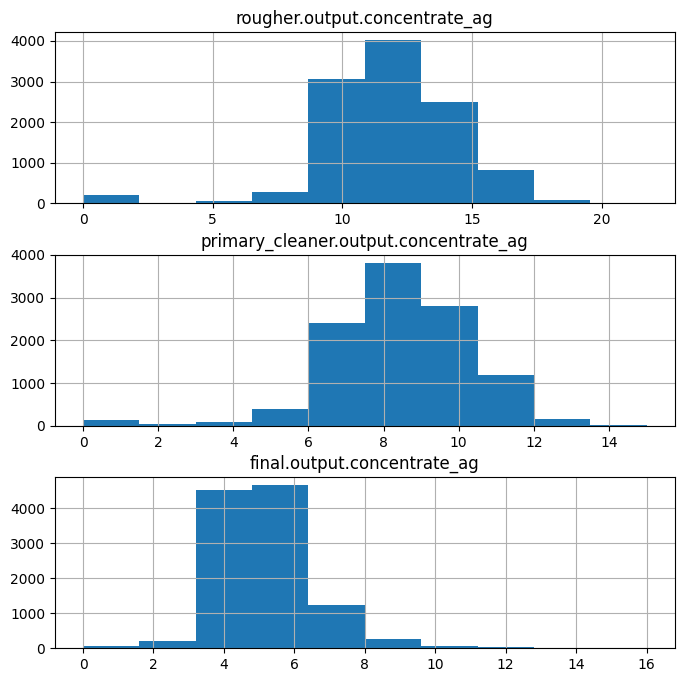

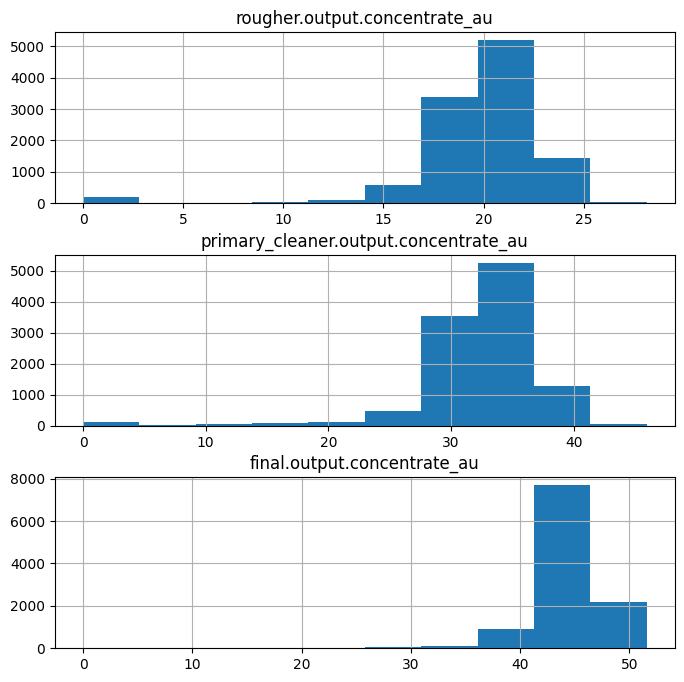

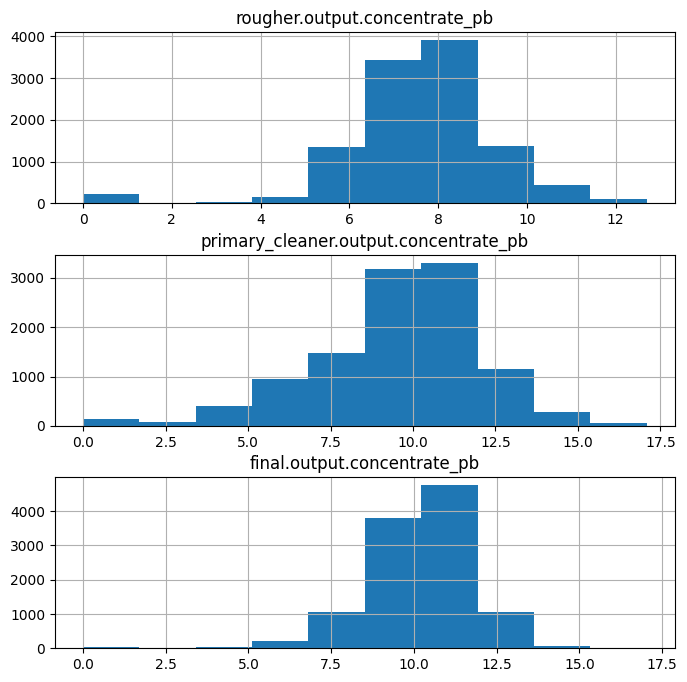

In [10]:
# Get concentrations for each metal to plot in histogram to visualize distribution of concentrations after each step

# Ag Concentation
ag_concentrations = gold_recovery_train[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]

# Au Concentation
au_concentrations = gold_recovery_train[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au','final.output.concentrate_au']]

# Pb Concentation
pb_concentrations = gold_recovery_train[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]

# Plot Ag Concentration Information and Histograms
print('Ag Concentration Change at Each Purification Step')
print('The mean Ag concentration before primary purification is', round(ag_concentrations['rougher.output.concentrate_ag'].mean(),2))
print('The mean Ag concentration before secondary purification is', round(ag_concentrations['primary_cleaner.output.concentrate_ag'].mean(),2))
print('The mean Ag concentration after secondary purification is', round(ag_concentrations['final.output.concentrate_ag'].mean(),2))

fig, axis = plt.subplots(3,1,figsize=(8, 8))
ag_concentrations.hist(ax=axis)

print()

# Plot Au Concentration Information and Histograms
print('Au Concentration Change at Each Purification Step')
print('The mean Au concentration before primary purification is', round(au_concentrations['rougher.output.concentrate_au'].mean(),2))
print('The mean Au concentration before secondary purification is', round(au_concentrations['primary_cleaner.output.concentrate_au'].mean(),2))
print('The mean Au concentration after secondary purification is', round(au_concentrations['final.output.concentrate_au'].mean(),2))

fig, axis = plt.subplots(3,1,figsize=(8, 8))
au_concentrations.hist(ax=axis)

print()

# Plot Pb Concentration Information and Histograms
print('Pb Concentration Change at Each Purification Step')
print('The mean Pb concentration before primary purification is', round(pb_concentrations['rougher.output.concentrate_pb'].mean(),2))
print('The mean Pb concentration before secondary purification is', round(pb_concentrations['primary_cleaner.output.concentrate_pb'].mean(),2))
print('The mean Pb concentration after secondary purification is', round(pb_concentrations['final.output.concentrate_pb'].mean(),2))

fig, axis = plt.subplots(3,1,figsize=(8, 8))
pb_concentrations.hist(ax=axis)

print()

**Findings -** During the process of gold extraction, at each stage we see that - 
 - **Silver (Ag)** concentration increases after primary purification but decreases after secondary purification
 - **Gold (Au)** concentration increases after purification process
 - **Lead (Pb)** concentration also interestingly enough increases throughout the purification process

### Comparison of Particle Size Distributions
Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect


Note that the **feed size** stage refers to the feed particle size. There are two fields in the training set that relate to feed size are - 
 - 'primary_cleaner.input.feed_size'
 - 'rougher.input.feed_size'

**We will evaluate how the particle sizes differ between training set and test set in this section**

Particle Size Distribution For Training Set
The average particle size before the floatation step is 57.22
The average particle size before the first step of purification input is 7.4

Particle Size Distribution For Test Set
The average particle size before the floatation step is 55.86
The average particle size before the first step of purification input is 7.27


Text(0.5, 0.98, 'Particle Size Distribution For Training Set')

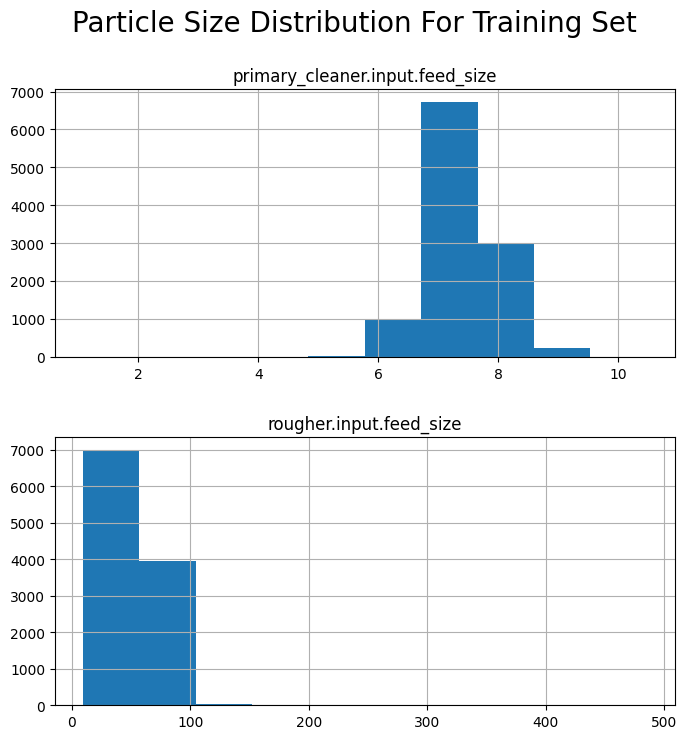

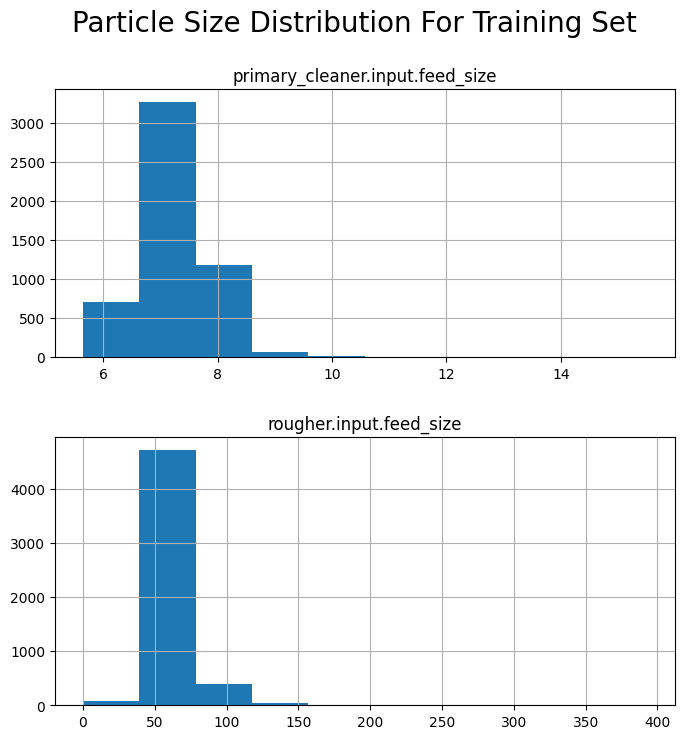

In [11]:
# Get feed sizes between train and test set
train_feed_size = gold_recovery_train[['primary_cleaner.input.feed_size','rougher.input.feed_size']]
test_feed_size = gold_recovery_test[['primary_cleaner.input.feed_size','rougher.input.feed_size']]

# Training
# Plot Particle Size Distribution For Training Set
print('Particle Size Distribution For Training Set')
print('The average particle size before the floatation step is', round(train_feed_size['rougher.input.feed_size'].mean(),2))
print('The average particle size before the first step of purification input is', round(train_feed_size['primary_cleaner.input.feed_size'].mean(),2))

fig, axis = plt.subplots(2,1,figsize=(8, 8))
train_feed_size.hist(ax=axis)
fig.suptitle('Particle Size Distribution For Training Set', fontsize=20)

# Test
# Plot Particle Size Distribution For Test Set
print()
print('Particle Size Distribution For Test Set')
print('The average particle size before the floatation step is', round(test_feed_size['rougher.input.feed_size'].mean(),2))
print('The average particle size before the first step of purification input is', round(test_feed_size['primary_cleaner.input.feed_size'].mean(),2))

fig, axis = plt.subplots(2,1,figsize=(8, 8))
test_feed_size.hist(ax=axis)
fig.suptitle('Particle Size Distribution For Training Set', fontsize=20)


**Findings -** When looking at the differences in particle size distribution between the training and test dataset
 - There is little to no difference between particle size for `rougher.input.feed_size` or `primary_cleaner.input.feed_size`
 
*__Please note__* that visual differences may be caused by auto scaling x-axis on histogram but there is not difference in the actual distribution of the data itself
 


### Analyze Concentrations of All Substances at Different Stages
Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 

Text(0.5, 0.98, 'Final Concentrate Total')

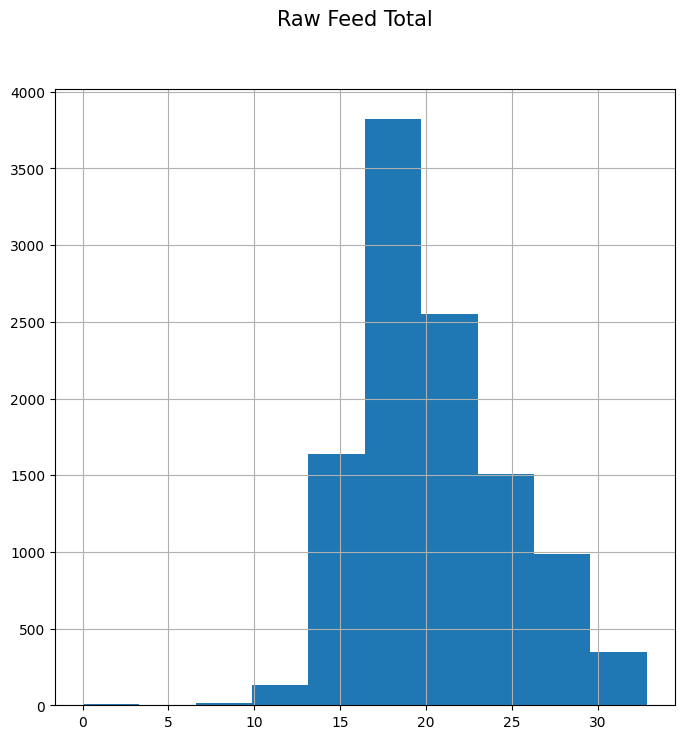

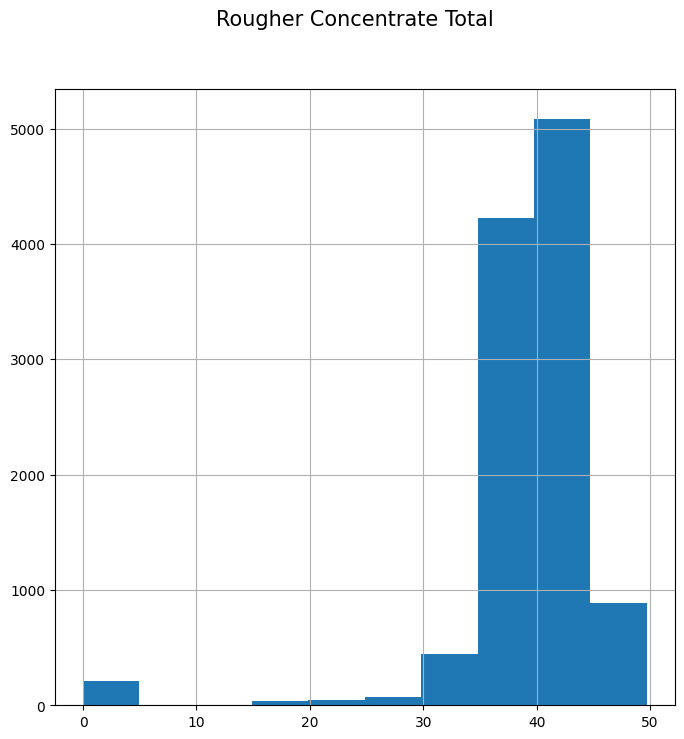

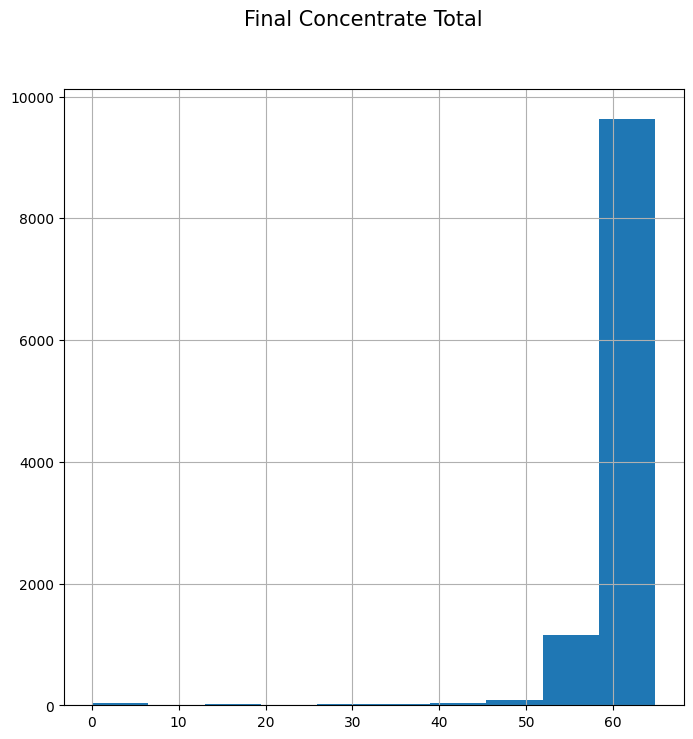

In [12]:
# Sum concentrations of metals at each stage and plot distributions

# Calculate Raw Feed Totals
# Using rougher.input.feed_
gold_recovery_train['total_raw_feed'] = gold_recovery_train[['rougher.input.feed_ag','rougher.input.feed_au','rougher.input.feed_pb']].sum(axis=1)

# Raw Feed Distribution 
fig, axis = plt.subplots(1,1,figsize=(8, 8))
gold_recovery_train['total_raw_feed'].hist(ax=axis)
fig.suptitle('Raw Feed Total', fontsize=15)



# Calculate Rougher Concentrate Totals
# Using rougher.input.feed_
gold_recovery_train['total_rough_concentrate'] = gold_recovery_train[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']].sum(axis=1)

# Raw Feed Distribution 
fig, axis = plt.subplots(1,1,figsize=(8, 8))
gold_recovery_train['total_rough_concentrate'].hist(ax=axis)
fig.suptitle('Rougher Concentrate Total', fontsize=15)



# Calculate Final Concentrate Totals
# Using rougher.input.feed_
gold_recovery_train['total_final_concentrate'] = gold_recovery_train[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']].sum(axis=1)

# Raw Feed Distribution 
fig, axis = plt.subplots(1,1,figsize=(8, 8))
gold_recovery_train['total_final_concentrate'].hist(ax=axis)
fig.suptitle('Final Concentrate Total', fontsize=15)


#### Describe Findings & Eliminate Anomalies

**Findings -** From looking at the each of the total distributions in the histograms, it looks like the variance of the data decreases at each stage. For example, there is a much wider variance when looking at raw feed total compared to the final concentrate total. This might be because the gold extraction process generally produces a similiar final concentration no matter the composition of the raw feed. Outside of this, I don't see any anomolies to remove from the dataset.

## Build The Model
We need to build a model that predicts two values - 
 - **rougher concentrate recovery** (*rougher.output.recovery*)
 - **final concentrate recovery** (*final.output.recovery*)
 
Because we are trying to predict a value, and not a classification (0 or 1), we are going to test and evaluate several regression models on the training data before making a recomendation on what model type to works best for prediciting gold extration concentrations.

### Write a Function to Calculate the Final sMAPE Value

**Some conxtent about sMAPE -** Symmetric Mean Absolute Percentage Error, is designed to account for the relative difference between predicted and actual values, considering their magnitudes in a balanced manner. Unlike other error measures, sMAPE assigns equal weight to overestimations and underestimations. 

The resulting SMAPE values range from 0% to 100%, with lower values indicating higher accuracy. A SMAPE value of 0% signifies a perfect alignment between the forecasted and actual values, while a value of 100% implies no similarity between the two.

*__The formula for calculating SMAPE is defined in the screenshot and the parameters are defined as:__*

 - **yi** - Value of target for the observation with the i index in the sample used to measure quality
 - **y^i** - Value of prediction for the observation with the i index, for example, in the test sample
 - **N** - Number of observations in the sample
 - **Sigma** - Summation over all observations of the sample (i takes values from 1 to N). 

![sMAPE](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_smape_1576239058_1589899769.jpg)

The model that we will build will need to predict two values:
- rougher concentrate recovery `rougher.output.recovery`
- final concentrate recovery `final.output.recovery`

We will use the Final sMAPE equation below to evaluate how well our models are predicting final gold concentrations. **The closer the Final sMAPE is to 0, the higher the accuracy of the model**

![Final sMAPE](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved__smape_1589899561.jpg)

In [13]:
# Create function to calculate sMAPE
def smape(true_value, predicted_value):
    smape = np.nanmean(abs(predicted_value - true_value) / ((abs(true_value) + abs(predicted_value)) / 2)) * 100 
    return smape

# Create function to calculate final sMAPE
def final_smape(true_value, predicted_value):
    predicted_rough, predicted_final = predicted_value[:, 0], predicted_value[:, 1]
    true_rough, true_final = true_value[:, 0], true_value[:, 1]
    fsmape = (.25 * (smape(true_rough, predicted_rough))) + (.75 * (smape(true_final, predicted_final)))
    return fsmape

### Train Different Regression Models & Evaluate Them Using Cross-Validation
Pick the best model and test it using the test sample. Provide findings. The formulas below will be used for evaluation metrics - 
 - **sMAPE**
 - **Final sMAPE**
     - (25% * sMAPE(rougher)) + (75% * sMAPE(final))

#### Split Training & Test Datasets into Features & Target Sets
In this step, we will split out the training and test data into features and targets. Specifically for the tranining dataset, we want have the features in the tranining dataset match the features in the test dataset so that the model isn't overfitted when we fit the model and predict target values on the test set.  

In [14]:
# Create target and feature datasets using training set
# The variable difference from Section 3.3

# Remove rows from test and train where the targets are 0 to avoid division by 0 warning in sMAPE calculation
gold_recovery_train = gold_recovery_train[(gold_recovery_train['final.output.recovery'] > 0) | (gold_recovery_train['rougher.output.recovery'] > 0)]
gold_recovery_test = gold_recovery_test[(gold_recovery_test['final.output.recovery'] > 0) | (gold_recovery_test['rougher.output.recovery'] > 0)]

# Training ########################################

# Filter the fields in the training dataset to those in the test set
# Also drop date

features_train = gold_recovery_train[gold_recovery_test.columns]
#features_train = gold_recovery_train.drop(difference, axis = 1).reset_index(drop=True)
features_train = features_train.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis = 1).reset_index(drop=True)

# Training Target
target_train = gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)


# Test ########################################

# Create features_test and target_test
# Test Features
features_test = gold_recovery_test.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis = 1).reset_index(drop=True)

# Test Target
target_test = gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)

# Print Shape of Training & Test Data
print('Training Dataset')
print(features_train.shape)
print(target_train.shape)
print()
print('Test Dataset')
print(features_test.shape)
print(target_test.shape)


Training Dataset
(11016, 52)
(11016, 2)

Test Dataset
(5229, 52)
(5229, 2)


**Before training the models, I want to add some content on how cross_val_score will be used in the training our regression models.** cross_val_score is a function that generates a cross-validated accuracy score for each data point of our dataset. It splits the data set into multiple subsets of training and testing data, trains the model on each training subset, performs predictions on the testing subset, and outputs the prediction accuracy score for each subset. The process repeats depending on the number of cross-validations we have set.

By default, cross_val_score() will use a default scoring function for whichever model we have specified. For example, if we have a RandomForestClassifer as the estimator, the default scoring function is the mean overall accuracy. For most regression models, it will return the R-squared value. If we want to use a different scoring function, we can create a scorer by using the make_scorer() method, and specifying the scoring metric that you want to use. **For our models, we want to score on final_smape.** To do this, we can create a scorer for the final_smape function by calling make_scorer(). We set the scoring parameter in the cross_val_score function equal to the newly created final_smape scorer.

In [15]:
# Create a scorer for our regression models 
final_smape_score = make_scorer(final_smape)

#### Determine Baseline sMAPE on Training Data 

In [16]:
# Create a baseline to compare the regression models to in terms of sMAPE
target_train_copy = target_train.copy()

# Determine the mean for each training target to compare the true training target values to 
target_train_copy['rougher.output.recovery'] = target_train['rougher.output.recovery'].mean()
target_train_copy['final.output.recovery'] = target_train['final.output.recovery'].mean()

# Run final_smape function on true target training values vs target train averages
print('Average sMAPE on Training Set Targets is')
print(final_smape(target_train.values, target_train_copy.values))

Average sMAPE on Training Set Targets is
9.868110300789947


#### Train LinearRegression Model

In [17]:
# Initialize Linear Regression Model 
lr_model = LinearRegression().fit(features_train, target_train)

# cv — number of blocks for cross-validation (by default, it's 3)
lr_scores = cross_val_score(lr_model, features_train.values, target_train.values, cv=5, scoring=final_smape_score)

# Print Average sMAPE
print('The Average sMAPE for a LinearRegression Model is:', np.nanmean(lr_scores))

# Print Scores From Cross Validation
print()
print('The sMAPE scores from each fold of cross-validation were')
print(lr_scores)

The Average sMAPE for a LinearRegression Model is: 10.241634441095822

The sMAPE scores from each fold of cross-validation were
[11.23921526  8.8223779   9.23831194 10.77586697 11.13240013]


#### Train DecisionTreeRegressor Model

In [18]:
%%time

# Create a for loop to tune the DecisionTreeRegressor model 
# We want to optimize for max_depth to get the lowest Final sMAPE
for depth in range(1, 11):
# Initialize Decision Tree Regression Model 
    dtr_model = DecisionTreeRegressor(max_depth = depth, random_state=12345).fit(features_train, target_train)

    # Perfrom cross validation with scoring
    dtr_scores = cross_val_score(dtr_model, features_train.values, target_train.values, cv=5, scoring=final_smape_score)

    # Print Scores From Cross Validation
    print()
    print('With max_depth set to', depth,'- the Average Final sMAPE was', np.nanmean(dtr_scores))
    print('sMAPE scores from subsets of cross-validation were', dtr_scores)


With max_depth set to 1 - the Average Final sMAPE was 10.06763046128861
sMAPE scores from subsets of cross-validation were [ 9.33930085  9.49262289  8.03440493 10.78090823 12.69091541]

With max_depth set to 2 - the Average Final sMAPE was 9.236532504156234
sMAPE scores from subsets of cross-validation were [ 8.60400598  8.34327836  6.97923918 11.74815152 10.50798747]

With max_depth set to 3 - the Average Final sMAPE was 9.25751534695352
sMAPE scores from subsets of cross-validation were [ 8.80408925  8.34778591  7.76710965 11.81882806  9.54976387]

With max_depth set to 4 - the Average Final sMAPE was 9.818087866941466
sMAPE scores from subsets of cross-validation were [10.1184638   8.68310312  8.07750476 12.22762304  9.98374461]

With max_depth set to 5 - the Average Final sMAPE was 10.249365085966966
sMAPE scores from subsets of cross-validation were [10.21433846  9.98399063  7.43348847 12.42625977 11.1887481 ]

With max_depth set to 6 - the Average Final sMAPE was 10.389979102374

#### Train RandomForestRegressor Model

In [19]:
%%time

# Create a for loop to tune the RandomForestRegressor model 
# We want to optimize for n_estimators to get the lowest Final sMAPE
for est in range(1, 11):
    # Initialize Random Forrest Regression Model 
    rfr_model = RandomForestRegressor(n_estimators=est, random_state= 12345).fit(features_train, target_train)

    # Perfrom cross validation with scoring
    rfr_scores = cross_val_score(rfr_model, features_train.values, target_train.values, cv=5, scoring=final_smape_score)

    # Print average scores for each subset of cross validation using Decision Tree Regression Model 
    #print('The Average sMAPE for a RandomForestRegressor Model is:', np.nanmean(rfr_scores))

    # Print Scores From Cross Validation
    print()
    print('With n_estimator set to', est,'- the Average Final sMAPE was', np.nanmean(rfr_scores))
    print('sMAPE scores from subsets of cross-validation were', rfr_scores)


With n_estimator set to 1 - the Average Final sMAPE was 17.550211993120794
sMAPE scores from subsets of cross-validation were [17.56464451 14.41963661 16.98694899 18.97805843 19.80177143]

With n_estimator set to 2 - the Average Final sMAPE was 16.795127119123077
sMAPE scores from subsets of cross-validation were [14.84704827 11.99436389 15.81646816 17.0562558  24.26149948]

With n_estimator set to 3 - the Average Final sMAPE was 15.381096733750818
sMAPE scores from subsets of cross-validation were [13.8907326  11.07323763 15.56593178 15.8430219  20.53255976]

With n_estimator set to 4 - the Average Final sMAPE was 14.505895892559504
sMAPE scores from subsets of cross-validation were [13.4439039  10.97692469 14.16418603 15.74341454 18.20105031]

With n_estimator set to 5 - the Average Final sMAPE was 13.890135112181383
sMAPE scores from subsets of cross-validation were [12.71837259 12.47180352 12.64136315 15.29874631 16.32038999]

With n_estimator set to 6 - the Average Final sMAPE wa

#### Compare Results of the Models

Here is the performance of each model after tuning to minizme the Final sMAPE - 
 - **Baseline Using Mean Target Values for sMAPE** - 9.86
 - **LinearRegression** - Average Final sMAPE of 10.21
 - **DecisionTreeRegressor** - Average Final sMAPE of  9.23 With max_depth set to 2.
 - **RandomForestRegressor** - Average Final sMAPE of 12.86 With n_estimators set to 7.

**Given that the DecisionTreeRegressor Model has the lowest average Final sMAPE, and this sMAPE is lower than the baseline, this is the model that I will use to predict target values with on our test dataset.**

### Pick The Best Model & Use it on Test Sample
Before we evaluate the RandomForestRegressor model on the test data, we need to establish a baseline first so that we can determine if the model RandomForestRegressor performs well compared to a model that 

To do this we will use a **DummyRegressor model** which is a model that makes predictions using simple rules while ignoring the input features. In this instance, we want the DummyRegressor strategy to predict the average of the test targets so we set the strategy to mean. A DummyRegressor is useful to provide a sanity check and to compare performance against actual Regressors.

#### Get Baseline Prediction Using DummyRegressor

In [20]:
# Get baseline sMAPE to compare chosen model to

# Checking sMAPE for median value for all predictions
# Fit model to traning data
dummy_regressor = DummyRegressor(strategy='mean').fit(features_train, target_train)

# Predict test target values
target_predictions = dummy_regressor.predict(features_test)

# Print sMAPE for DummyRegressor
print('The Average sMAPE for a DummyRegressor Model is:', final_smape(target_test.values, target_predictions))

The Average sMAPE for a DummyRegressor Model is: 9.732597277057659


#### Evaluate DecisionTreeRegressor Model Predictions on Test Dataset Targets

In [21]:
# Initialize Decision Tree Regression Model 
dtr_model = DecisionTreeRegressor(max_depth = 5, random_state=12345).fit(features_train, target_train)

# Use Model to Predict Target Values on Scaled Test Set
predicted_test = dtr_model.predict(features_test)

# Print sMAPE for DummyRegressor
print('The Average sMAPE for a DecisionTreeRegressor Model is:', final_smape(target_test.values, predicted_test))

The Average sMAPE for a DecisionTreeRegressor Model is: 9.383606040490927


## Conclusion

Compared to the baseline results of the DummyRegressor model (9.73), **the DecisionTreeRegressor produces a slightly better model performance in regards to Final sMAPE (9.38).** Given these results, I would implement a DecisionTreeRegressor model for Zyfra to predict the amount of gold recovered from gold ore with the smallest mean average error between the true values and predict values.